In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [ ]:
data = pd.read_csv('/content/training_set.csv')

In [ ]:
X = data.drop('SOURCE', axis=1)
y = data['SOURCE']

In [ ]:
# use one-hot encoding to convert 'string' to numerical values
X = pd.get_dummies(X, columns = ['SEX'], drop_first=True)

# Model Training

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42)

In [ ]:
gbc = GradientBoostingClassifier(random_state = 42)

gbc.fit(X_train, y_train)

y_train_pred = gbc.predict(X_train)
y_val_pred = gbc.predict(X_val)
y_test_pred = gbc.predict(X_test)

# 報告
print("=== GBC Training Report ===")
print(classification_report(y_train, y_train_pred))

print("=== GBC Validation Report ===")
print(classification_report(y_val, y_val_pred))

print("=== GBC Test Report ===")
print(classification_report(y_test, y_test_pred))

=== GBC Training Report ===
              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1403
           1       0.82      0.67      0.74       913

    accuracy                           0.81      2316
   macro avg       0.82      0.79      0.80      2316
weighted avg       0.81      0.81      0.81      2316

=== GBC Validation Report ===
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       197
           1       0.77      0.66      0.71       134

    accuracy                           0.78       331
   macro avg       0.78      0.76      0.77       331
weighted avg       0.78      0.78      0.78       331

=== GBC Test Report ===
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       392
           1       0.71      0.54      0.61       270

    accuracy                           0.72       662
   macro avg       0.72      0.69      0.70   

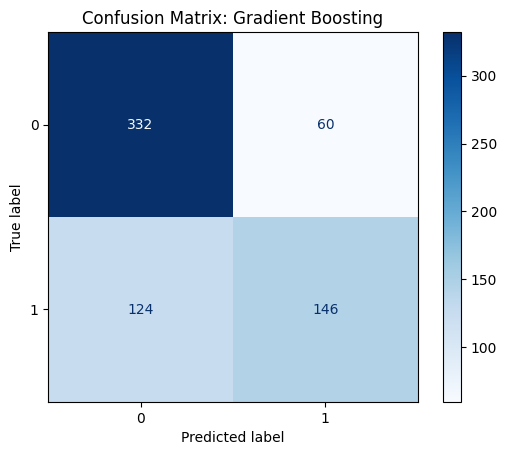

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix: Gradient Boosting")
plt.show()

# Tune the parameters

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Shrinks the contribution of each tree
    'max_depth': [3, 5, 7],              # Maximum depth of individual trees
    'min_samples_split': [2, 5],         # Min samples required to split an internal node
    'subsample': [0.8, 1.0]              # Fraction of samples used for fitting the trees
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,              # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,         # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.7564757578014448


In [ ]:
# Evaluate the model on validation set
best_gb = grid_search.best_estimator_
val_predictions = best_gb.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_predictions = best_gb.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Validation accuracy: 0.7946
Test accuracy: 0.7205

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       392
           1       0.70      0.54      0.61       270

    accuracy                           0.72       662
   macro avg       0.72      0.69      0.70       662
weighted avg       0.72      0.72      0.71       662



**Tuning Result**

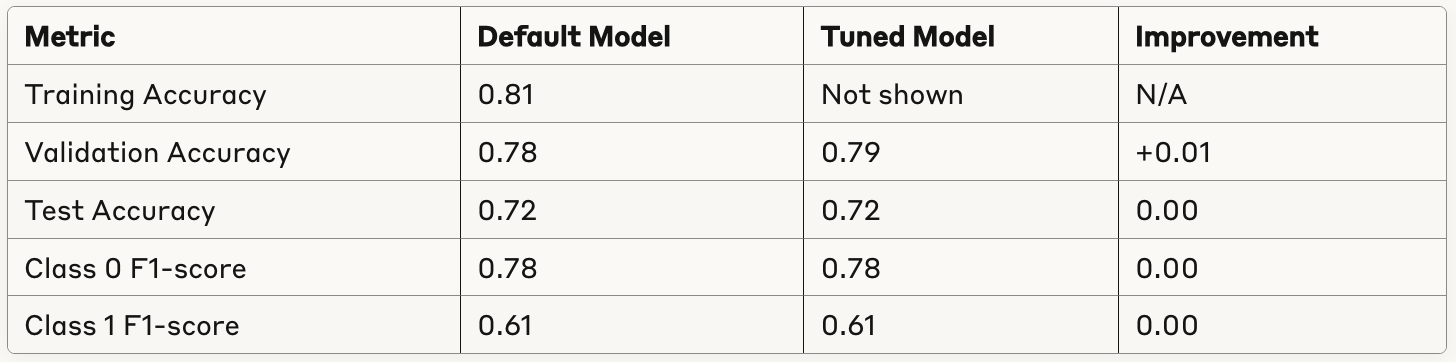

From the result, we can see that there is only a minimal improvement in the gradient boosting model. The validation accuracy increases by 0.01, but the test accuracy remains unchanged. Unlike the decision tree and random forest model, which showed an obvious overfitting problem, the gradient boosting model already had a good balance between training and testing.

1. Parameter analysis :


*  Learning rate: This parameter controls how big each step is when a gradient-boosting model tries to correct its mistakes. The default is usually 0.1, but the tuning result reduced it to 0.05, which makes the model learn more slowly but often more accurately.
*  Max depth: This limits each tree to a maximum depth of 3, which is much shallower than the default setting (unlimited). Shallow trees in gradient boosting help prevent overfitting by focusing on the strongest patterns.
*  n_estimators: Increasing from the default 100 to 200 trees compensates for the lower learning rate. More trees with a lower learning rate often improve performance by making more careful, gradual improvements.
*  min_samples_split: Similar to the other models, increasing this from the default value of 2 means nodes only split if they have at least five samples, creating more robust splits.

2. Conclusion: The gradient boosting model showed good performance with default parameters, achieving similar test accuracy after tuning. From my observation, the most influential parameters are the learning rate and the number of estimators. The lower learning rate combining the larger number of trees allows the model to make more careful adjustments. The max depth limits to 3 also prevent the model from overfitting. Despite careful tuning, the gradient boosting model only improved very little, showing that the default parameters are quite suitable for this dataset.

# Feature Importance

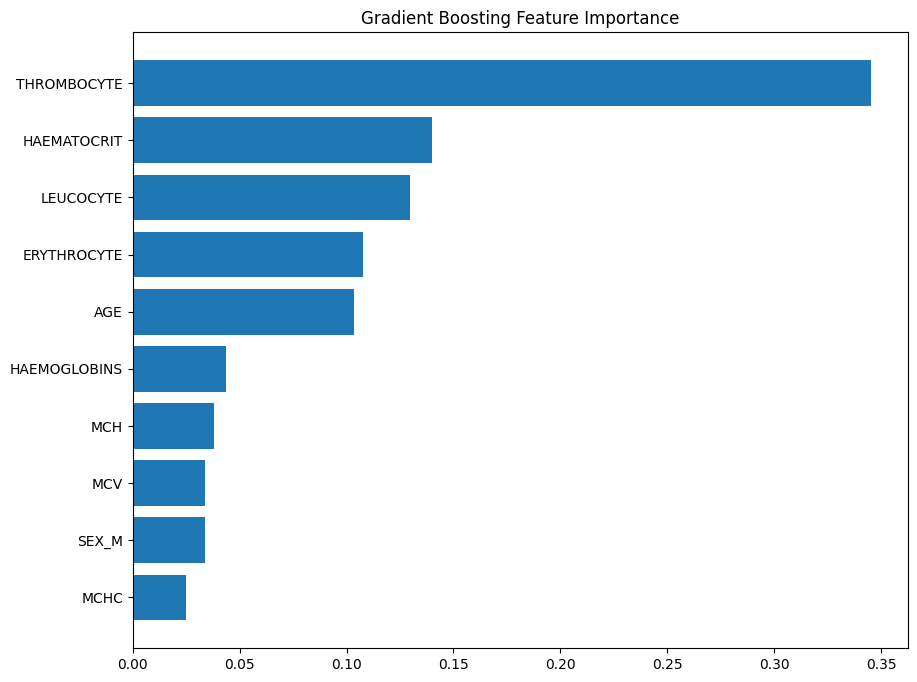

In [ ]:
# Feature importance analysis
feature_importance = best_gb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Gradient Boosting Feature Importance')
plt.show()

In [ ]:
importance_df = pd.DataFrame(
    {'Feature' : feature_names,
    'Importance' : feature_importance}
).sort_values(by='Importance', ascending=False)
print(importance_df)

        Feature  Importance
4   THROMBOCYTE    0.345305
0   HAEMATOCRIT    0.140016
3     LEUCOCYTE    0.129707
2   ERYTHROCYTE    0.107714
8           AGE    0.103269
1  HAEMOGLOBINS    0.043498
5           MCH    0.038124
7           MCV    0.033677
9         SEX_M    0.033668
6          MCHC    0.025022


In [ ]:
threshold = 0.05
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

In [ ]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

best_gb.fit(X_train_selected, y_train)
selected_test_preds = best_gb.predict(X_test_selected)
selected_test_acc = accuracy_score(y_test, selected_test_preds)

print("\n--- Model with Selected Features Performance ---")
print(f"Test Accuracy: {selected_test_acc:.4f}")
print("\nClassification Report (Feature-Selected Model):")
print(classification_report(y_test, selected_test_preds))


--- Model with Selected Features Performance ---
Test Accuracy: 0.7085

Classification Report (Feature-Selected Model):
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       392
           1       0.69      0.52      0.59       270

    accuracy                           0.71       662
   macro avg       0.70      0.68      0.68       662
weighted avg       0.71      0.71      0.70       662



**Feature Selection Report**

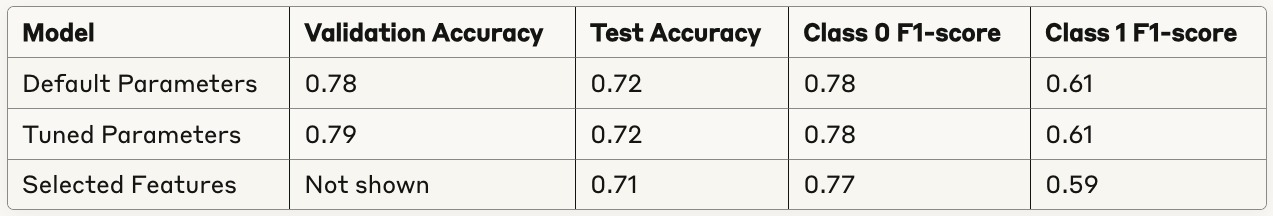

I trained the selected features (threshold = 0.05) with the optimized model (the model with tuned parameters). Since there are only 10 features, I set the threshold to 0.05 to extract features. The table shows that feature selection doesn't improve a lot. It may be because the original set of features wasn't that large. Besides, the gradient boosting model is already good at handling these medical sets since it focuses on important features through sequential learning. The main benefits of feature selection would be:


*  Simpler model and potentially faster training and prediction times
*  Identifying which blood markers are most important for classification

